Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Micro-Ultrasound Prostate Segmentation with MONAI

This tutorial demonstrates how to perform 2D prostate segmentation using MONAI on the Micro-Ultrasound Prostate Segmentation Dataset.

**Target:** Prostate  
**Modality:** Micro-Ultrasound  
**Task:** Segmentation

The tutorial covers:
1. How to download the dataset using python/ the notebook. 
2. Setting up preprocessing steps by defining a custom `NiftiCineFrameDataset` and other general steps. 
3. Defining training and validation transforms and how to effectively use them from MONAI's repertoire of datasets.
4. Setting up UNet model from MONAI's networks module adn how to train it for segmentation.
5. Training and validation loops.
6. Visualize results after training. 


## Additional notes 
- The Micro-Ultrasound Prostate Segmentation Dataset can be downloaded from [Zenodo](https://zenodo.org/record/10475293).
- The samples are stored in NIfTI files, hence each sample is stored as a 3D "volume", with time being the thrid dimension. To solve this, we will define a custom Dataset class to preprocess the data by converting each slice in the file to a separate 2D image. Then we will group the images sample-wise to prevent any data leaks.  


In [1]:
%env BUILD_MONAI=1
!pip install -q "monai[all] @ git+https://github.com/Project-MONAI/MONAI.git"

env: BUILD_MONAI=1

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!python -c "import monai" || pip install -q "monai[itk, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [3]:
import os
import urllib.request
import zipfile
import matplotlib.pyplot as plt

from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, Resized, Activations, AsDiscrete
from monai.data import DataLoader, decollate_batch
from torch.utils.data import Dataset, Subset
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from pathlib import Path
import torch

import nibabel as nib
import numpy as np


In [4]:
ROOT_DIR = "./dataset_test"  # Define the target directory for data storage; created if it doesn't exist
os.makedirs(ROOT_DIR, exist_ok=True)
print(f"Dataset will be stored in: {os.path.abspath(ROOT_DIR)}")

Dataset will be stored in: /teamspace/studios/this_studio/wg-ultrasound/data_and_tutorials/dataset_test


## Dataset Setup

This tutorial uses MONAI's standard dataset classes instead of a custom dataset class. We'll:
1. Download the dataset using `urllib.request` and `zipfile`
2. Generate data lists manually
3. Use MONAI's `Dataset` or `CacheDataset` classes for loading

**Note:** The original custom dataset class is preserved below (commented out) for reference.


## Download Dataset

Download the Micro-Ultrasound Prostate Segmentation Dataset from Zenodo using `urllib.request` and extract it using `zipfile`.


In [5]:
# Dataset configuration
DATASET_URL = "https://zenodo.org/record/10475293/files/Micro_Ultrasound_Prostate_Segmentation_Dataset.zip"
ZIP_FILE_NAME = "Micro_Ultrasound_Prostate_Segmentation_Dataset.zip"
DATASET_FOLDER_NAME = "Micro_Ultrasound_Prostate_Segmentation_Dataset"

zip_path = Path(ROOT_DIR) / ZIP_FILE_NAME
dataset_folder = Path(ROOT_DIR) / DATASET_FOLDER_NAME

# Download dataset if not already present
if not dataset_folder.exists():
    if not zip_path.exists():
        print(f"Downloading dataset from {DATASET_URL}...")
        urllib.request.urlretrieve(DATASET_URL, zip_path)
        print("Download complete!")
    else:
        print(f"Zip file already exists: {zip_path}")

    # Extract the dataset
    print(f"Extracting dataset to {ROOT_DIR}...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(ROOT_DIR)
    print("Extraction complete!")
else:
    print(f"Dataset already extracted at: {dataset_folder}")

# Verify dataset folder exists
if not dataset_folder.exists():
    raise RuntimeError(f"Dataset folder missing: {dataset_folder}")
else:
    print(f"Dataset ready at: {dataset_folder}")


Download complete!
Extracting dataset to ./dataset_test...
Extraction complete!
Dataset ready at: dataset_test/Micro_Ultrasound_Prostate_Segmentation_Dataset


## Generate Data Lists

Create data lists that map image files to their corresponding annotation files. This function handles the mapping logic for different annotation types.


In [6]:
# Annotation type mappings
ANNOTATION_MAP = {
    "expert": "expert_annotations",
    "non_expert": "non_expert_annotations",
    "master": "master_student_annotations",
    "medical": "medical_student_annotations",
    "clinician": "clinician_annotations",
}

FILE_PREFIX_MAP = {
    "expert": "expert_annotation",
    "non_expert": "non_expert_annotation",
    "master": "master_student_annotation",
    "medical": "medical_student_annotation",
    "clinician": "clinician_annotation",
}


def generate_data_list(root_dir, section, annotation_type="expert"):
    """
    Generate a list of dictionaries containing image and label file paths.
    
    Args:
        root_dir: Root directory containing the dataset
        section: Either "training" or "test"
        annotation_type: Type of annotation to use (default: "expert")
    
    Returns:
        List of dictionaries with "image" and "label" keys
    """
    root_dir = Path(root_dir)
    dataset_folder = root_dir / DATASET_FOLDER_NAME
    
    if annotation_type not in ANNOTATION_MAP:
        raise ValueError(f"Unsupported annotation_type: {annotation_type}")
    
    if section not in ["training", "test"]:
        raise ValueError("section must be 'training' or 'test'")
    
    # Map "training" to "train" folder name
    section_folder = "train" if section == "training" else "test"
    section_dir = dataset_folder / section_folder
    image_dir = section_dir / "micro_ultrasound_scans"
    label_dir = section_dir / ANNOTATION_MAP[annotation_type]
    
    if not image_dir.is_dir() or not label_dir.is_dir():
        raise RuntimeError(f"Missing required folders: {image_dir} or {label_dir}")
    
    # Find all image files (.nii.gz)
    image_files = sorted(f for f in image_dir.iterdir() if f.name.endswith(".nii.gz"))
    print(f"Found {len(image_files)} image files.")
    
    data_list = []
    label_prefix = FILE_PREFIX_MAP[annotation_type]
    
    for img in image_files:
        # Remove "microUS_" prefix to get the base filename
        suffix = img.name.replace("microUS_", "")
        label_name = f"{label_prefix}_{suffix}"
        label_path = label_dir / label_name
        
        if not label_path.exists():
            print(f"Warning: label missing for {img.name}, expected {label_name}")
            continue
        
        data_list.append({
            "image": str(img),
            "label": str(label_path),
        })
    
    if not data_list:
        raise RuntimeError("No subjects found. Check dataset structure.")
    
    print(f"Final paired subjects: {len(data_list)}")
    return data_list


# Creating a custom dataset to process the labels and images

We use nibabel and numpy to extract an array of `HxWxT` and convert it into `T` arrays/ images of size `HxW`

In [7]:
class NiftiCineFrameDataset(Dataset):
    """
    Treats a cine NIfTI (H, W, T) as T independent 2D samples.
    """

    def __init__(self, data, transforms=None):
        """
        Args:
            data: list of dicts with keys {"image": path, "label": path}
            transforms: MONAI dictionary transforms (2D)
        """
        self.data = data
        self.transforms = transforms

        # Cache full cine volumes
        self._image_cache = []
        self._label_cache = []

        # (cine_idx, frame_idx)
        self.index_map = []

        for cine_idx, item in enumerate(data):
            img_nii = nib.load(item["image"])
            lbl_nii = nib.load(item["label"])

            img_np = img_nii.get_fdata().astype(np.float32)  # (H, W, T)
            lbl_np = lbl_nii.get_fdata().astype(np.int64)    # (H, W, T)

            assert img_np.shape == lbl_np.shape, (
                f"Image/label shape mismatch: {item}"
            )

            self._image_cache.append(img_np)
            self._label_cache.append(lbl_np)

            num_frames = img_np.shape[2]
            for t in range(num_frames):
                self.index_map.append((cine_idx, t))

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        cine_idx, frame_idx = self.index_map[idx]

        image = self._image_cache[cine_idx][:, :, frame_idx]
        label = self._label_cache[cine_idx][:, :, frame_idx]

        sample = {
            "image": image,  # (H, W)
            "label": label,  # (H, W)
        }

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample


Creating the trainging and validation lists

In [8]:
# Generate data list for training section
train_data_list = generate_data_list(
    root_dir=ROOT_DIR,
    section="training",
    annotation_type="expert"
)

# Split into training and validation (80/20 split)
train_size = int(0.8 * len(train_data_list))
val_size = len(train_data_list) - train_size
train_indices = list(range(train_size))
val_indices = list(range(train_size, len(train_data_list)))

# Create training and validation data lists
train_data = [train_data_list[i] for i in train_indices]
val_data = [train_data_list[i] for i in val_indices]

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Found 55 image files.
Final paired subjects: 55
Training samples: 44
Validation samples: 11


## Setup transforms for training and validation

For this example we will be simple transforms. For a more robust model, the below can be followed. transforms for:
- **Training**: Include data augmentation (random crops, rotations, flips) to improve model generalization
- **Validation**: Only includes necessary preprocessing (load, ensure channel first, spacing, intensity scaling)


In [9]:
train_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim = "no_channel"),  # (1, H, W)
    Resized(keys=["image", "label"], spatial_size=(1376, 960), mode=["bilinear", "nearest"]), # Resizing to a size divisible by 8 to mitigate shape erros during model training. 
    ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
])

val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim = "no_channel"),
    Resized(keys=["image", "label"], spatial_size=(1376, 960), mode=["bilinear", "nearest"]),
    ScaleIntensityd(keys="image", minv=0.0, maxv=1.0),
])


Initializing datasets with the chosen transforms and data

In [10]:
train_ds = NiftiCineFrameDataset(
    data=train_data,
    transforms=train_transforms,
)

val_ds_subset = NiftiCineFrameDataset(
    data=val_data,
    transforms=val_transforms,
)

print(f"Training frames: {len(train_ds)}")
print(f"Validation frames: {len(val_ds_subset)}")


Training frames: 1721
Validation frames: 431


In [11]:
from torch.utils.data import DataLoader

loader = DataLoader(train_ds, batch_size=1)
batch = next(iter(loader))

print(batch["image"].shape)
print(batch["label"].shape)


torch.Size([1, 1, 1376, 960])
torch.Size([1, 1, 1376, 960])


## Check data shape and visualize a sample

Image shape: torch.Size([1, 1, 1376, 960]), Label shape: torch.Size([1, 1, 1376, 960])
metatensor([0.])


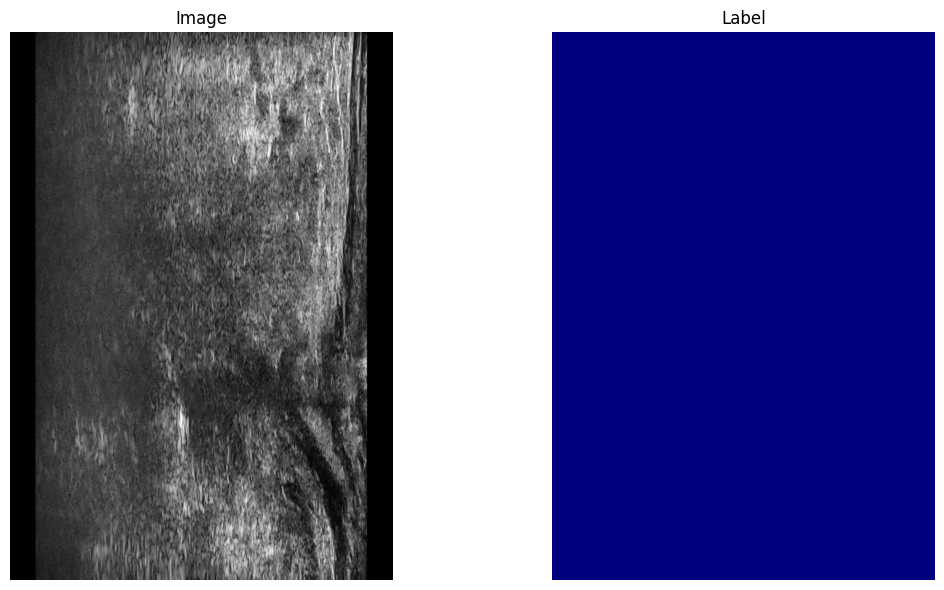

In [12]:
from monai.config import print_config
from monai.utils import set_determinism, first

# Check a sample from training data to determine data shape
check_loader = DataLoader(train_ds, batch_size=1, num_workers=0)
check_data = first(check_loader)
image, label = check_data["image"], check_data["label"]
print(f"Image shape: {image.shape}, Label shape: {label.shape}")
print(torch.unique(label))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# print(image)
axes[0].imshow(image[0,0].cpu().numpy(), cmap="gray")
axes[0].set_title("Image")
axes[0].axis("off")
axes[1].imshow(label[0, 0].cpu().numpy(), cmap="jet")
axes[1].set_title("Label")
axes[1].axis("off")
plt.tight_layout()


The above check shows us that the image and label are being loaded properly, but just for an additional sanity check, well will check the number of 0s and 1s

In [13]:
import collections

label_values = collections.Counter()

for i in range(len(train_ds)):
    sample = train_ds[i]
    uniq = torch.unique(sample["label"])
    label_values.update(uniq.tolist())

print(label_values)

Counter({0.0: 1721, 1.0: 1545})


## Create Model, Loss, and Optimizer

We'll use a UNet model segmentation with Dice Loss and Adam optimizer.


In [14]:
spatial_dims = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Using {spatial_dims}D UNet")

# Create UNet model
model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,
    out_channels=2,  # Background + foreground
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    norm=("batch", {"eps": 1e-5, "momentum": 0.1}),
).to(device)

# Loss function
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Metric
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Post-processing transforms
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cuda
Using 2D UNet
Model parameters: 402,761


## Training loop

Execute the training process with validation at each epoch. We'll use a simple implementation of Early Stopping to stop overfitting.  


In [15]:
max_epochs = 100
val_interval = 1

best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []

# Early stopping params
patience = 15              # number of validation runs
min_delta = 0.001
no_improve_count = 0
early_stop = False

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(val_ds_subset, batch_size=1, num_workers=0)

print("Starting training...")
for epoch in range(max_epochs):
    if early_stop:
        break

    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()

    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        epoch_len = len(train_ds) // train_loader.batch_size
        if step % 100 == 0:
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # ----------------- VALIDATION -----------------
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_labels = val_data["label"].to(device)


                val_outputs = model(val_inputs)

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()

        metric_values.append(metric)

        # Early Stopping
        if metric-best_metric > min_delta:
        # if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            no_improve_count = 0

            torch.save(
                model.state_dict(),
                os.path.join(ROOT_DIR, "best_metric_model.pth"),
            )
            print("Saved new best metric model")
        else:
            no_improve_count += 1
            print(
                f"No improvement for {no_improve_count}/{patience} validation runs"
            )

        print(
            f"Current epoch: {epoch + 1}, mean dice: {metric:.4f}\n"
            f"Best mean dice: {best_metric:.4f} at epoch {best_metric_epoch}"
        )

        if no_improve_count >= patience:
            print("Early stopping triggered.")
            early_stop = True

print(
    f"Training completed! Best metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
)


Starting training...
----------
Epoch 1/100


100/860, train_loss: 0.4596
200/860, train_loss: 0.4618
300/860, train_loss: 0.3650
400/860, train_loss: 0.4569
500/860, train_loss: 0.5204
600/860, train_loss: 0.3068
700/860, train_loss: 0.2542
800/860, train_loss: 0.3139
Epoch 1 average loss: 0.4194
Saved new best metric model
Current epoch: 1, mean dice: 0.6614
Best mean dice: 0.6614 at epoch 1
----------
Epoch 2/100
100/860, train_loss: 0.2601
200/860, train_loss: 0.3675
300/860, train_loss: 0.2606
400/860, train_loss: 0.2370
500/860, train_loss: 0.2076
600/860, train_loss: 0.4490
700/860, train_loss: 0.3949
800/860, train_loss: 0.4798
Epoch 2 average loss: 0.3064
Saved new best metric model
Current epoch: 2, mean dice: 0.7217
Best mean dice: 0.7217 at epoch 2
----------
Epoch 3/100
100/860, train_loss: 0.4398
200/860, train_loss: 0.1986
300/860, train_loss: 0.1492
400/860, train_loss: 0.3854
500/860, train_loss: 0.3684
600/860, train_loss: 0.2086
700/860, train_loss: 0.1784
800/860, train_loss: 0.4537
Epoch 3 average loss: 0.2687

## Plot training loss and validation metric


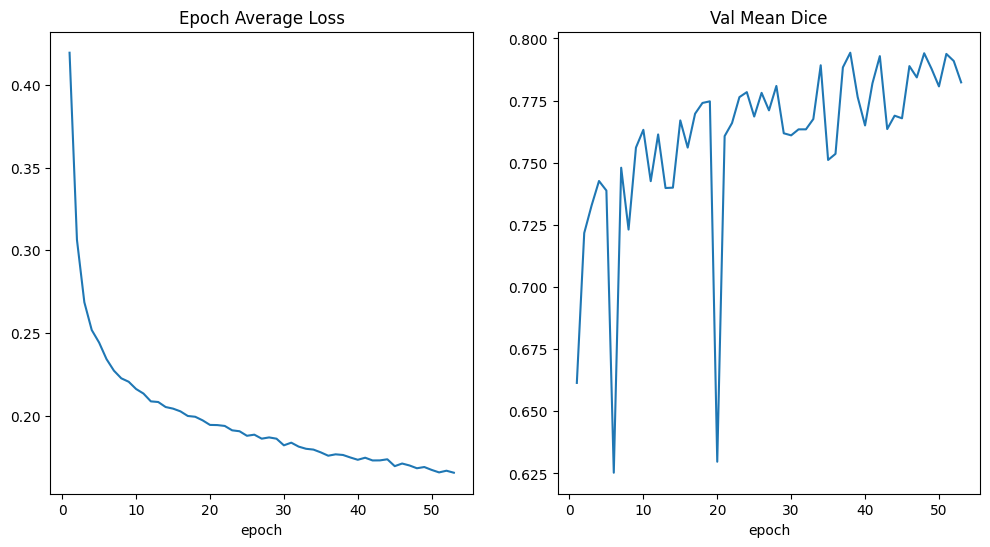

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


## Visualize best model predictions

Load the best model and visualize predictions on validation samples.


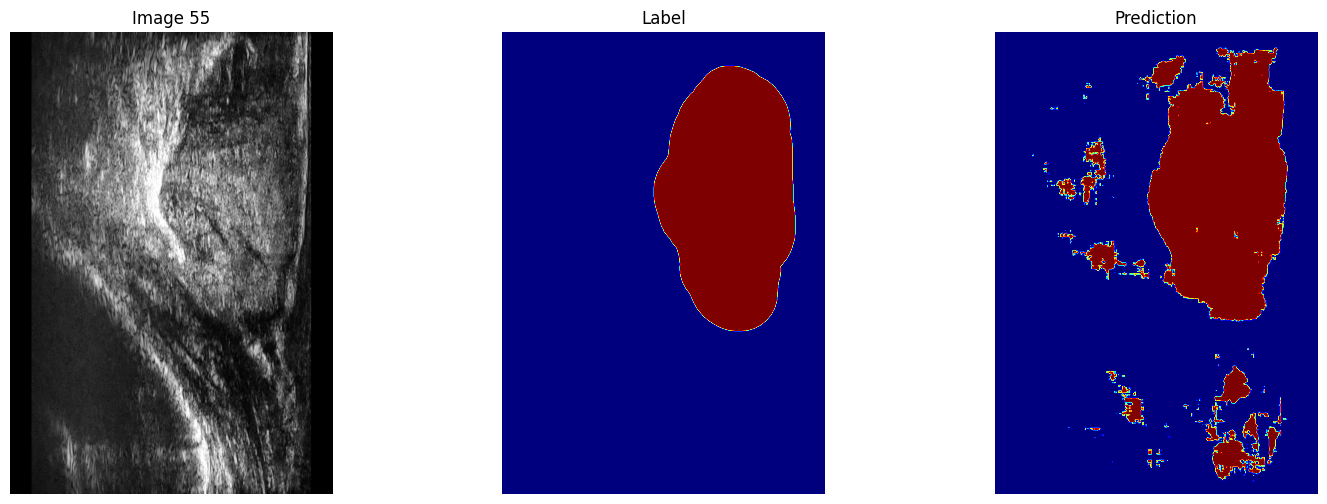

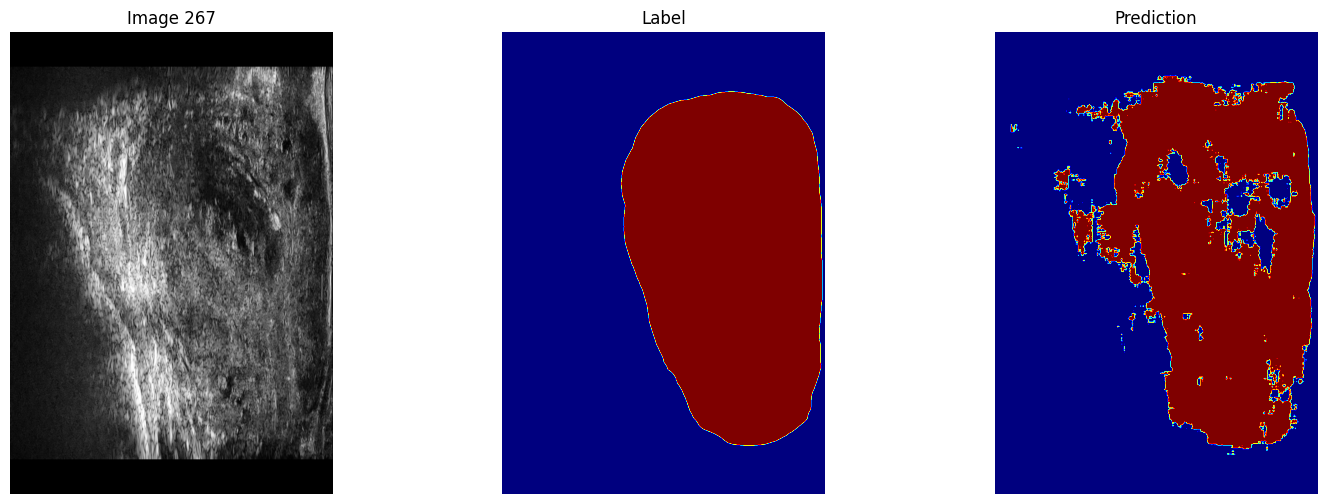

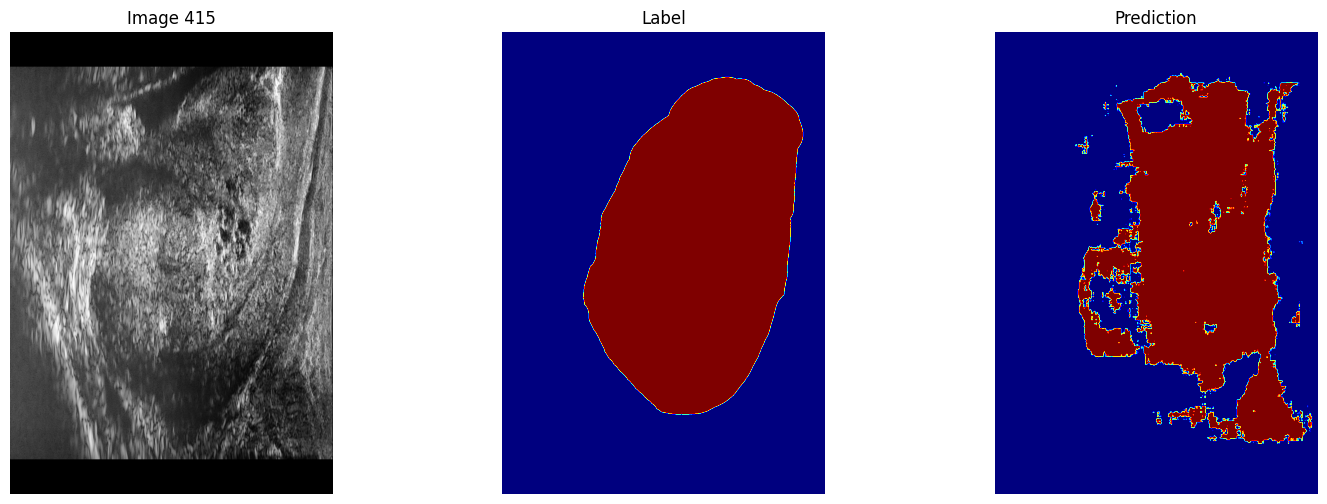

In [17]:
import random

model.load_state_dict(torch.load(os.path.join(ROOT_DIR, "best_metric_model.pth"), weights_only=True))
model.eval()

val_loader = DataLoader(val_ds_subset, batch_size=1, num_workers=0)

num_vis = 3
random_indices = set(random.sample(range(len(val_loader)), num_vis))

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i not in random_indices:
            continue

        val_inputs = val_data["image"].to(device)
        val_outputs = model(val_inputs)

        if spatial_dims == 3:
            slice_idx = val_inputs.shape[-1] // 2
            img_slice = val_inputs[0, 0, :, :, slice_idx].cpu()
            label_slice = val_data["label"][0, 0, :, :, slice_idx].cpu()
            pred_slice = val_outputs.argmax(dim=1)[0, :, :, slice_idx].cpu()
        else:
            img_slice = val_inputs[0, 0].cpu()
            label_slice = val_data["label"][0, 0].cpu()
            pred_slice = val_outputs.argmax(dim=1)[0].cpu()

        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Image {i}")
        plt.imshow(img_slice, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(label_slice, cmap="jet")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(pred_slice, cmap="jet")
        plt.axis("off")

        plt.show()
